In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deap



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 4.6 MB/s eta 0:00:00



===== Station 19091 | MIX + Lags Vazão & PRP + GA σ (v6.8_balanced_prp_operacional) =====
[GA] σ_scale ótimo=1.250 | p=0.81 | r=1.21 | width_ratio=2.07

[Train Metrics]
         RMSE       MAE        R2       NSE       KGE     PBIAS   PEARSON  \
0  13.499043  9.693355  0.882844  0.882844  0.850587  1.811018  0.945381   

   NSE_picos  
0   0.306043  

[Test Metrics]
         RMSE        MAE        R2       NSE       KGE     PBIAS   PEARSON  \
0  44.589475  31.307993  0.646252  0.646252  0.746295  1.539692  0.804491   

   NSE_picos  
0  -0.620154  

[Tabela Mensal de Cobertura — Últimos 24 Meses]
       Ano  Mês         Obs        Pred         Low          Up Coberto
287  2021   12  198.560226  160.511641   85.106136  235.917145       ✅
288  2022    1  265.357893  183.304231  107.799194  258.809269       ❌
289  2022    2  152.365677  168.222477   94.259008  242.185945       ✅
290  2022    3  178.242200  115.214572   83.653407  146.775738       ❌
291  2022    4  116.788903   87.369218 

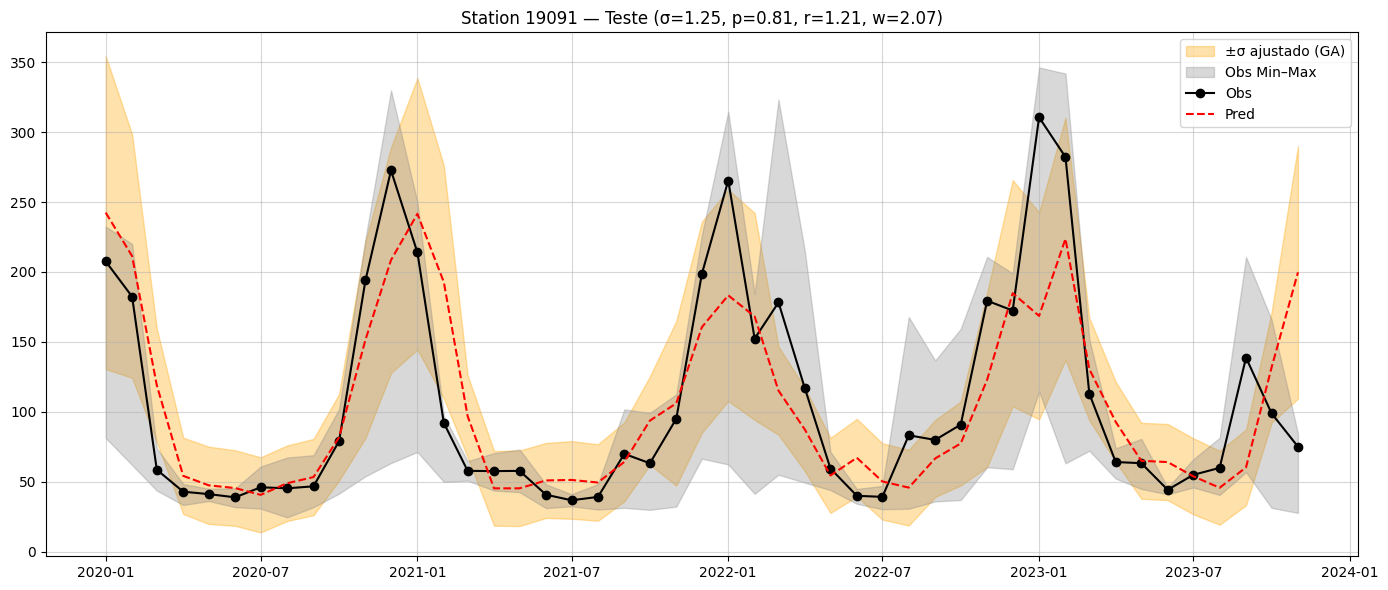

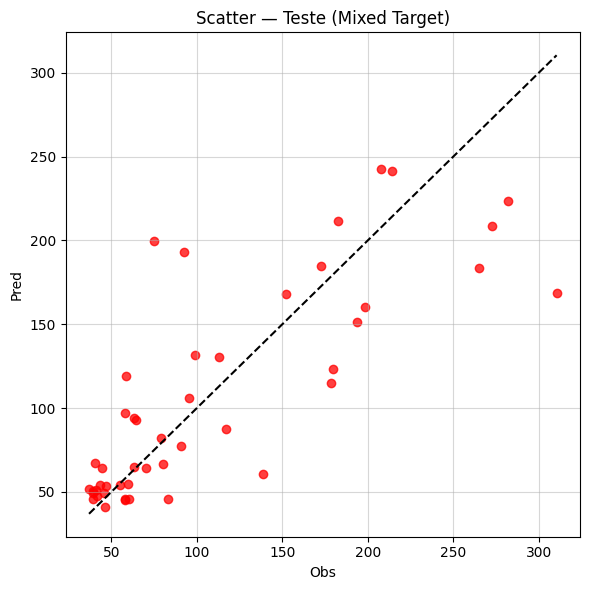

In [ ]:
# =============================================================================
# v6.8_balanced_prp_operacional — Mix Models + 3 Lags Vazão + 3 Lags PRP + GA Balanceado
# =============================================================================
# NOVO:
#   • Inclusão de lags e índice antecedente de precipitação (pr_lag1-3, pr_sum3, pr_api3)
#   • max_depth=5 no XGB para capturar interação chuva–vazão
#   • Penalização GA moderada (0.15)
#   • Faixa sazonal ligeiramente mais aberta em Nov–Fev
#   • Exportação automática de resultados (Excel + figuras)
# =============================================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from deap import base, creator, tools, algorithms
import random, openpyxl

# ========================== CONFIG ==========================
DATA_PATH = Path("/content/drive/MyDrive/PREVISÃO-VAZAO-FUNIL/agragado_meteo_vazao_shifted_station_19091_extended.csv")
OUTPUT_PATH = Path("/content/drive/MyDrive/PREVISÃO-VAZAO-FUNIL/resultados_funil_v6.8_prp.xlsx")

FEATS_BASE = ["u2_min","u2_max","tmin_min","tmin_max","tmax_min","tmax_max",
              "rs_min","rs_max","rh_min","rh_max","eto_min","eto_max","pr_min","pr_max"]
COL_YEAR, COL_MONTH = "year","month"

# ========================== FUNÇÕES ==========================
def nse(y_true,y_pred):
    denom = np.sum((y_true - np.mean(y_true))**2)
    return 1 - np.sum((y_true - y_pred)**2)/denom if denom != 0 else np.nan

def kge(y_true,y_pred):
    r = pearsonr(y_true,y_pred)[0]
    mo, ms = np.mean(y_true), np.mean(y_pred)
    beta = ms/mo if mo!=0 else np.nan
    cvo = np.std(y_true,ddof=1)/mo if mo!=0 else np.nan
    cvs = np.std(y_pred,ddof=1)/ms if ms!=0 else np.nan
    gamma = cvs/cvo if cvo!=0 else np.nan
    return 1 - np.sqrt((r-1)**2 + (beta-1)**2 + (gamma-1)**2)

def pbias(y_true,y_pred):
    return 100*np.sum(y_true - y_pred)/np.sum(y_true)

def metrics(y_true,y_pred,UF):
    return dict(
        RMSE=np.sqrt(mean_squared_error(y_true,y_pred)),
        MAE=mean_absolute_error(y_true,y_pred),
        R2=r2_score(y_true,y_pred),
        NSE=nse(y_true,y_pred),
        KGE=kge(y_true,y_pred),
        PBIAS=pbias(y_true,y_pred),
        PEARSON=pearsonr(y_true,y_pred)[0],
        NSE_picos=nse(y_true[y_true>UF],y_pred[y_true>UF]) if np.any(y_true>UF) else np.nan
    )

def mad_sigma(res):
    med = np.median(res)
    return 1.4826 * np.median(np.abs(res - med))

# ========================== ROTINA PRINCIPAL ==========================
def run_station_mix_GA_v68_prp():
    print("\n===== Station 19091 | MIX + Lags Vazão & PRP + GA σ (v6.8_balanced_prp_operacional) =====")

    df = pd.read_csv(DATA_PATH).sort_values([COL_YEAR,COL_MONTH]).copy()

    # ===== Precipitação média e lags =====
    df["pr_mean"] = (df["pr_min"] + df["pr_max"]) / 2.0
    df["pr_lag1"] = df["pr_mean"].shift(1)
    df["pr_lag2"] = df["pr_mean"].shift(2)
    df["pr_lag3"] = df["pr_mean"].shift(3)
    df["pr_sum3"] = df["pr_mean"].rolling(3,min_periods=1).sum().shift(1)
    df["pr_api3"] = (0.5*df["pr_mean"].shift(1) + 0.3*df["pr_mean"].shift(2) + 0.2*df["pr_mean"].shift(3))

    # ===== Lags da vazão =====
    df["y_lag1"]=df["flow_next_month"].shift(1)
    df["y_lag2"]=df["flow_next_month"].shift(2)
    df["y_lag3"]=df["flow_next_month"].shift(3)
    df["y_rm3"]=df["flow_next_month"].rolling(3,min_periods=1).mean().shift(1)

    needed = FEATS_BASE + ["flow_next_month","flow_next_month_max","flow_next_month_min",
                           COL_YEAR,COL_MONTH,"y_lag1","y_lag2","y_lag3","y_rm3",
                           "pr_mean","pr_lag1","pr_lag2","pr_lag3","pr_sum3","pr_api3"]
    df = df.dropna(subset=needed).copy()
    df[COL_YEAR] = df[COL_YEAR].astype(int)
    df[COL_MONTH] = df[COL_MONTH].astype(int)
    df["month_sin"] = np.sin(2*np.pi*df[COL_MONTH]/12)
    df["month_cos"] = np.cos(2*np.pi*df[COL_MONTH]/12)

    FEATS = FEATS_BASE + ["month_sin","month_cos","y_lag1","y_lag2","y_lag3","y_rm3",
                          "pr_lag1","pr_lag2","pr_lag3","pr_sum3","pr_api3"]

    # ===== Splits =====
    train = (df[COL_YEAR]>=1998)&(df[COL_YEAR]<=2017)
    val   = (df[COL_YEAR]>=2018)&(df[COL_YEAR]<=2019)
    test  = (df[COL_YEAR]>=2020)&(df[COL_YEAR]<=2023)

    X_tr = df.loc[train,FEATS].to_numpy()
    X_val= df.loc[val,FEATS].to_numpy()
    X_te = df.loc[test,FEATS].to_numpy()
    y_trA= df.loc[train,"flow_next_month"].to_numpy(float)
    y_trB= df.loc[train,"flow_next_month_max"].to_numpy(float)
    y_teA= df.loc[test,"flow_next_month"].to_numpy(float)
    y_teB= df.loc[test,"flow_next_month_max"].to_numpy(float)
    min_flow_te = df.loc[test,"flow_next_month_min"].to_numpy()
    max_flow_te = df.loc[test,"flow_next_month_max"].to_numpy()
    obs_width = np.maximum(1e-6, max_flow_te - min_flow_te)

    dates_te = pd.to_datetime(dict(year=df.loc[test,COL_YEAR],month=df.loc[test,COL_MONTH],day=1))
    Q1,Q3 = np.percentile(y_trA,[25,75]); UF = Q3 + 1.5*(Q3-Q1)

    scaler = StandardScaler().fit(np.vstack([X_tr,X_val]))
    X_tr_s,X_te_s = scaler.transform(X_tr),scaler.transform(X_te)

    # ===== Modelos A/B =====
    mlpA = MLPRegressor(hidden_layer_sizes=(64,32),alpha=2e-3,max_iter=3000,random_state=42,early_stopping=True)
    xgbA = XGBRegressor(n_estimators=900,learning_rate=0.02,max_depth=5,subsample=0.9,colsample_bytree=0.9,random_state=42)
    mlpA.fit(X_tr_s,y_trA); xgbA.fit(X_tr,y_trA)
    yhat_trA = 0.5*mlpA.predict(X_tr_s)+0.5*xgbA.predict(X_tr)
    yhat_teA = 0.5*mlpA.predict(X_te_s)+0.5*xgbA.predict(X_te)

    mlpB = MLPRegressor(hidden_layer_sizes=(64,32),alpha=2e-3,max_iter=3000,random_state=43,early_stopping=True)
    xgbB = XGBRegressor(n_estimators=900,learning_rate=0.02,max_depth=5,subsample=0.9,colsample_bytree=0.9,random_state=43)
    mlpB.fit(X_tr_s,y_trB); xgbB.fit(X_tr,y_trB)
    yhat_trB = 0.5*mlpB.predict(X_tr_s)+0.5*xgbB.predict(X_tr)
    yhat_teB = 0.5*mlpB.predict(X_te_s)+0.5*xgbB.predict(X_te)

    # ===== Ensemble adaptativo =====
    gate = np.where(df.loc[test,COL_MONTH].isin([11,12,1,2]),0.3,0.7)
    yhat_te = gate*yhat_teA + (1-gate)*yhat_teB
    y_te = gate*y_teA + (1-gate)*y_teB

    # ===== Incerteza =====
    sigma_A = mad_sigma(y_teA - yhat_teA)
    sigma_B = mad_sigma(y_teB - yhat_teB)
    w_desacordo = np.where(df.loc[test,COL_MONTH].isin([11,12,1,2]),0.22,0.08)
    sigma_mix = np.sqrt(gate*sigma_A**2 + (1-gate)*sigma_B**2 + w_desacordo*(yhat_teA-yhat_teB)**2)
    f_sazonal = np.where(df.loc[test,COL_MONTH].isin([11,12,1,2]),1.0,0.75)
    sigma_mix *= f_sazonal

    # ===== GA Balanceado =====
    target_p, target_r = 0.83, 1.10
    def fitness(ind):
        s = ind[0]
        σ = sigma_mix * s
        low,up = yhat_te-σ, yhat_te+σ
        p = np.mean((y_te>=low)&(y_te<=up))
        r = np.mean((up-low)/(np.std(y_te)+1e-6))
        width_ratio = np.mean((up-low)/obs_width)
        penalty = 0.0
        if width_ratio > 1.05:
            penalty -= 0.15 * (width_ratio - 1.05)
        return (-abs(p-target_p) - 0.2*abs(r-target_r) + penalty,)

    try: creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    except: pass
    try: creator.create("Individual", list, fitness=creator.FitnessMax)
    except: pass
    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, 0.5, 3.0)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.2)
    toolbox.register("mutate", tools.mutGaussian, mu=1.0, sigma=0.2, indpb=0.3)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", fitness)
    pop = toolbox.population(n=20)
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=25, verbose=False)
    best = tools.selBest(pop, 1)[0]; s_opt = best[0]

    σ = sigma_mix*s_opt
    low,up = yhat_te-σ,yhat_te+σ
    p = np.mean((y_te>=low)&(y_te<=up))
    r = np.mean((up-low)/(np.std(y_te)+1e-6))
    width_ratio = np.mean((up-low)/obs_width)
    print(f"[GA] σ_scale ótimo={s_opt:.3f} | p={p:.2f} | r={r:.2f} | width_ratio={width_ratio:.2f}")

    # ===== Métricas =====
    m_tr = metrics(y_trA,yhat_trA,UF)
    m_te = metrics(y_te,yhat_te,UF)
    print("\n[Train Metrics]\n",pd.DataFrame([m_tr]))
    print("\n[Test Metrics]\n",pd.DataFrame([m_te]))

    # ===== Cobertura mensal =====
    coverage = (y_te>=low)&(y_te<=up)
    df_te = pd.DataFrame({
        "Ano":df.loc[test,COL_YEAR],
        "Mês":df.loc[test,COL_MONTH],
        "Obs":y_te,"Pred":yhat_te,"Low":low,"Up":up,
        "Coberto":np.where(coverage,"✅","❌")
    })
    print("\n[Tabela Mensal de Cobertura — Últimos 24 Meses]\n",df_te.tail(24))

    # ===== Exportação Excel =====
    with pd.ExcelWriter(OUTPUT_PATH,engine="openpyxl") as writer:
        pd.DataFrame([m_tr]).to_excel(writer,sheet_name="Treino",index=False)
        pd.DataFrame([m_te]).to_excel(writer,sheet_name="Teste",index=False)
        df_te.to_excel(writer,sheet_name="Cobertura_Mensal",index=False)
    print(f"\n[Exportação] Resultados salvos em: {OUTPUT_PATH}")

    # ===== Decisão operacional =====
    if p>=0.8 and abs(m_te["PBIAS"])<=5:
        risco=" Baixo risco hidrológico — Faixa ajustada e confiável"
    elif p>=0.7:
        risco=" Risco médio — Cobertura aceitável, avaliar incerteza local"
    else:
        risco=" Alto risco — Banda subestima variabilidade, reavaliar incerteza"
    print(f"\n[Decisão Operacional Funil] {risco}")

    # ===== Figuras =====
    plt.figure(figsize=(14,6))
    plt.fill_between(dates_te,low,up,color="orange",alpha=0.33,label="±σ ajustado (GA)")
    plt.fill_between(dates_te,min_flow_te,max_flow_te,color="gray",alpha=0.30,label="Obs Min–Max")
    plt.plot(dates_te,y_te,"ko-",label="Obs")
    plt.plot(dates_te,yhat_te,"r--",label="Pred")
    plt.title(f"Station 19091 — Teste (σ={s_opt:.2f}, p={p:.2f}, r={r:.2f}, w={width_ratio:.2f})")
    plt.legend(); plt.grid(alpha=0.5); plt.tight_layout()
    plt.savefig(OUTPUT_PATH.parent / "serie_temporal_v6.8.png", dpi=300)
    plt.show()

    plt.figure(figsize=(6,6))
    plt.scatter(y_te,yhat_te,alpha=0.75,c="red")
    plt.plot([y_te.min(),y_te.max()],[y_te.min(),y_te.max()],"k--")
    plt.title("Scatter — Teste (Mixed Target)")
    plt.xlabel("Obs"); plt.ylabel("Pred")
    plt.grid(alpha=0.5); plt.tight_layout()
    plt.savefig(OUTPUT_PATH.parent / "dispersao_v6.8.png", dpi=300)
    plt.show()

# ========================== EXECUTAR ==========================
run_station_mix_GA_v68_prp()
